In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from re_forecast.data.manage_data_storage import read_register
from re_forecast.data.get_data import get_rte_units_names, get_rte_data

# Preprocessing

Aims of this notebook :  
- Clean all the datasets non present in the register, used for the developpement of the data package
- Construct a dataset and justify the choice of this dataset
- Formatting the datetime column
- First graphical view of the datas
- Detecting missing values and their number
- Propose methods to deal with missing datas

## Clean the datas used for the developpement of the data package

We want to clean all the datas non present in the register.

In [2]:
# Show the register
read_register()

,creation_date,ressource,start_date,end_date,eic_code,production_type,production_subtype,file_name
0,2024-03-12_14:15:18,actual_generations_per_production_type,2022-09-01_00:00:00,2023-09-01_00:00:00,NaN,all-units,NaN,actual_generations_per_production_type__2022-0...
1,2024-03-28_10:37:55,actual_generations_per_unit,2022-06-01_00:00:00,2024-03-01_00:00:00,all-units,NaN,NaN,actual_generations_per_unit__2022-06-01_00:00:...


## Choice of a dataset and download

We will choose a wind generation unit from ressource nb 2 (actual generation per unit), to ensure that the power of the generation assets we looking at does not change over time.

In [3]:
# Show the units names for the ressource nb 2
ressource_nb = 2
actual_generation_per_unit__unit = get_rte_units_names(ressource_nb = ressource_nb)

In [4]:
# Get the production types
actual_generation_per_unit__unit["production_type"].unique()

array(['FOSSIL_GAS', 'WIND_OFFSHORE', 'FOSSIL_HARD_COAL', 'FOSSIL_OIL',
       'HYDRO_RUN_OF_RIVER_AND_POUNDAGE', 'HYDRO_WATER_RESERVOIR',
       'HYDRO_PUMPED_STORAGE', 'NUCLEAR', 'OTHER', 'BIOMASS'],
      dtype=object)

In [5]:
# Display units names and filter for wind generation
wind_production_types = ["WIND_ONSHORE", "WIND_OFFSHORE"]
actual_generation_per_unit__unit.loc[actual_generation_per_unit__unit["production_type"].isin(wind_production_types), :]

,eic_code,name,production_type
3,17W0000014455651,BANC DE GUERANDE 1,WIND_OFFSHORE
4,17W000001445567Y,BANC DE GUERANDE 2,WIND_OFFSHORE
5,17W000001445569U,FECAMP 1,WIND_OFFSHORE
6,17W0000014455708,FECAMP 2,WIND_OFFSHORE
140,17W100P100P0842Y,A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE
142,17W100P100P3382R,A2 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE


Let's try out the 'BANC DE GUERANDE 1' generation unit, as it is the first operationnal wind offshore generation unit in France (https://www.eoliennesenmer.fr/facades-maritimes-en-france/facade-nord-atlantique-manche-ouest/saint-nazaire)

The operationnal start date of the generation unit 'BANC DE GUERANDE 1' can be found here : https://fr.wikipedia.org/wiki/Parc_%C3%A9olien_en_mer_de_Saint-Nazaire#cite_note-3

In [10]:
# Set the params
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = "17W0000014455651"
production_type = None
production_subtype = None

# Download: wait 1 hour between each api call
guerande_energy_generation = get_rte_data(ressource_nb = ressource_nb,
                                          start_date = start_date,
                                          end_date = end_date,
                                          eic_code = eic_code,
                                          production_type = production_type,
                                          production_subtype = production_subtype)

In [11]:
guerande_energy_generation

,start_date,end_date,updated_date,value,eic_code
788396,2023-03-03T22:00:00+01:00,2023-03-03T23:00:00+01:00,2023-03-03T23:25:47+01:00,107.0,17W0000014455651
788397,2023-03-03T23:00:00+01:00,2023-03-04T00:00:00+01:00,2023-03-04T00:23:08+01:00,136.0,17W0000014455651
788398,2023-03-04T00:00:00+01:00,2023-03-04T01:00:00+01:00,2023-03-04T01:24:06+01:00,127.0,17W0000014455651
788399,2023-03-04T01:00:00+01:00,2023-03-04T02:00:00+01:00,2023-03-07T14:05:05+01:00,109.0,17W0000014455651
788400,2023-03-04T02:00:00+01:00,2023-03-04T03:00:00+01:00,2023-03-04T03:23:02+01:00,85.0,17W0000014455651
...,...,...,...,...,...
1883021,2024-02-29T19:00:00+01:00,2024-02-29T20:00:00+01:00,2024-02-29T20:26:10+01:00,148.0,17W0000014455651
1883022,2024-02-29T20:00:00+01:00,2024-02-29T21:00:00+01:00,2024-02-29T21:23:57+01:00,190.0,17W0000014455651
1883023,2024-02-29T21:00:00+01:00,2024-02-29T22:00:00+01:00,2024-02-29T22:28:58+01:00,225.0,17W0000014455651
1883024,2024-02-29T22:00:00+01:00,2024-02-29T23:00:00+01:00,2024-02-29T23:24:01+01:00,196.0,17W0000014455651


In [4]:
read_register()

,creation_date,ressource,start_date,end_date,eic_code,production_type,production_subtype,file_name
0,2024-03-12_14:15:18,actual_generations_per_production_type,2022-09-01_00:00:00,2023-09-01_00:00:00,NaN,all-units,NaN,actual_generations_per_production_type__2022-0...
1,2024-03-28_10:37:55,actual_generations_per_unit,2022-06-01_00:00:00,2024-03-01_00:00:00,all-units,NaN,NaN,actual_generations_per_unit__2022-06-01_00:00:...


## Formatting the datetime columns

Inspect the missing values into the datetimes columns :

In [5]:
guerande_energy_generation.isnull().sum()

start_date      0
end_date        0
updated_date    0
value           0
eic_code        0
dtype: int64

Let's try to format one datetime column :

In [6]:
# Construct a function to transform str date columns to datetimes columns
def format_to_datetime(gen_df: pd.DataFrame,
                       dt_columns: list,
                       dt_format = "%Y-%m-%dT%H:%M:%S",
                       str_strip = "+01:00"
                       ) -> pd.DataFrame:
    """Format to datetime multiple columns of a df among a list of columns.
    Params:
    - dt_format: datetime format to respect
    - str_strip: string to remove from the input date"""

    # Iterate over the datetime columns
    for dt_column in dt_columns:
        try:
            # Strip the time zone
            gen_df[dt_column] = gen_df[dt_column]\
                .apply(lambda x: x.replace(str_strip, "") if x.endswith(str_strip) else x)

            # Transform to datetime
            gen_df[dt_column] = pd.to_datetime(gen_df[dt_column], format = dt_format)

        except:
            print("Wrong column name input")

    return gen_df

In [12]:
# pd.to_datetime(guerande_energy_generation["start_date"].apply(lambda x: x.replace("+01:00", "") if x.endswith("+01:00") else x), format = "%Y-%m-%dT%H:%M:%S")

788396     2023-03-03 22:00:00
788397     2023-03-03 23:00:00
788398     2023-03-04 00:00:00
788399     2023-03-04 01:00:00
788400     2023-03-04 02:00:00
                  ...         
1883021    2024-02-29 19:00:00
1883022    2024-02-29 20:00:00
1883023    2024-02-29 21:00:00
1883024    2024-02-29 22:00:00
1883025    2024-02-29 23:00:00
Name: start_date, Length: 6549, dtype: object

In [13]:
# Set the datetime columns names
dt_columns = ["start_date", "end_date", "updated_date"]

# Test the function
guerande_energy_generation_dt = format_to_datetime(guerande_energy_generation,
                                                   dt_columns = dt_columns)

In [14]:
# Check dtypes of the new formated df
guerande_energy_generation_dt.dtypes

start_date       object
end_date         object
updated_date     object
value           float64
eic_code         object
dtype: object

## First visualisation of the data

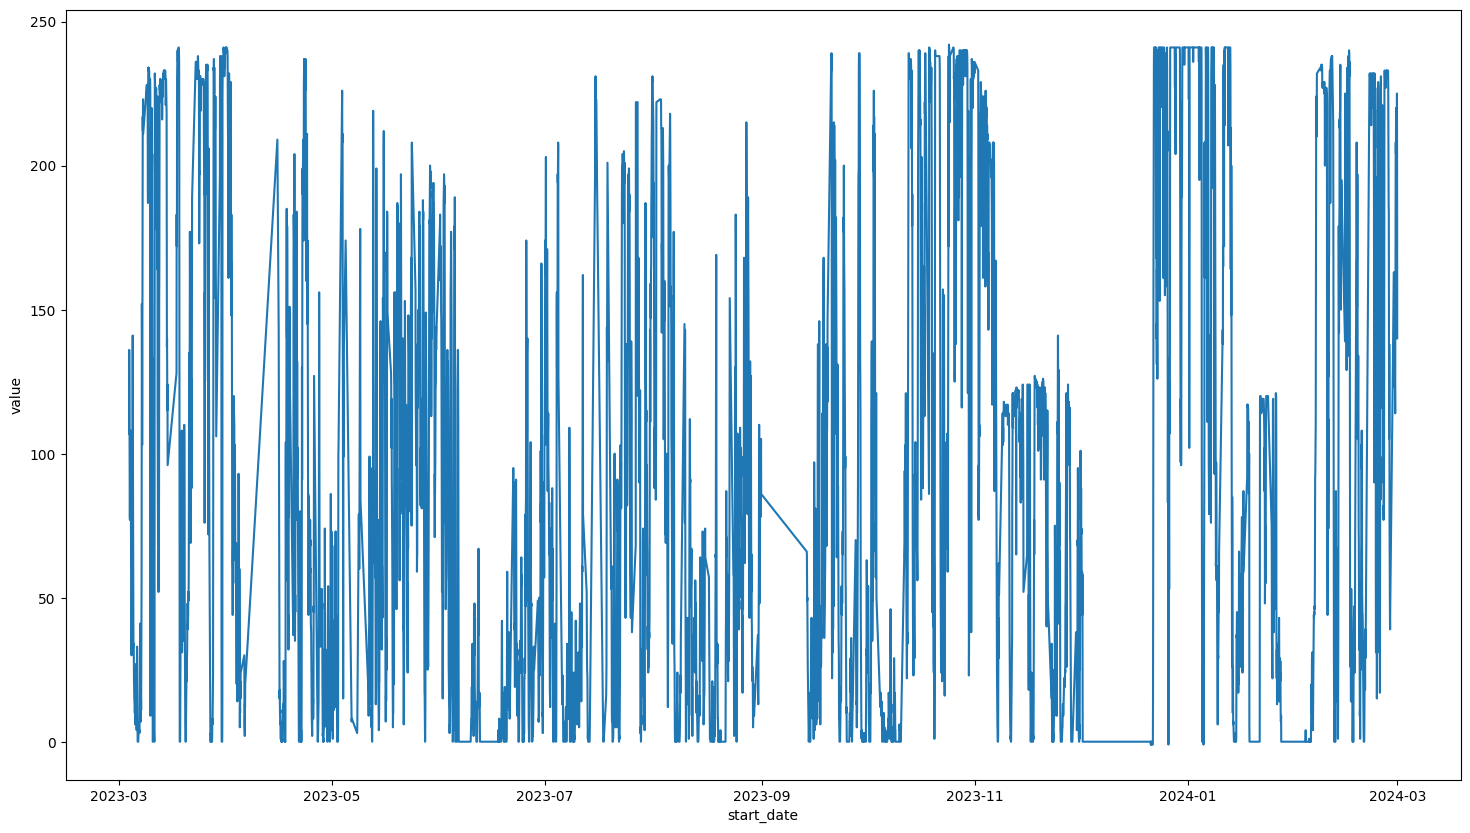

In [17]:
# Plot
plt.figure(figsize = (18, 10))
sns.lineplot(data = guerande_energy_generation_dt, x = "start_date", y = "value")
plt.show()